In [2]:
#imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from sklearn.model_selection import train_test_split
import seaborn as sns

In [3]:
#load the data 
from google.colab import files
uploaded = files.upload()
import io
data = pd.read_csv(io.BytesIO(uploaded['emotions.csv']),sep=',')
# a remplacer si ouvert sur jupyter notebook 
#data = pd.read_csv("adresse_relative/.../emotions.csv",sep=',')

Saving emotions.csv to emotions (1).csv


['NEGATIVE' 'NEUTRAL' 'POSITIVE']
(2132, 2549)


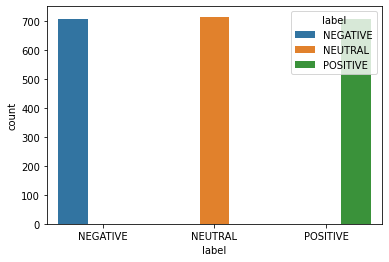

In [8]:
#what are the classes ?
print(data.label.unique()) #3 classes : NEGATIVE, NEUTRAL, POSITIVE
#how many features ?
print(data.shape)#2132 - 1 (label)
#distribution of the classes accross dataset?
ax = sns.countplot(x="label", hue="label", data=data)
#equal distribution of classes

In [5]:
#PCA
features=data.drop("label",axis=1)
labels=data.label
# scaling the features, not sure whether it was necessary but it seems to dramatically improve resuts
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_train_features = scaler.fit_transform(features)

In [6]:
#to make plots appear in the notebook
%matplotlib inline
from sklearn.decomposition import PCA
# Get our explained variance ratios from PCA using all features
pca = PCA()
pca.fit(scaled_train_features)
exp_variance = pca.explained_variance_ratio_
print(exp_variance)
print(pca.n_components_)
#Plot the cumulative explained variance ratio for the first 20 components.
fig, ax = plt.subplots()
ax.bar(range(20),pca.explained_variance_[0:20])


[3.67725641e-01 9.55389426e-02 8.43606900e-02 ... 2.03955650e-33
 2.03955650e-33 4.47976876e-35]
2132


Text(0.5, 0, 'Principal Component #')

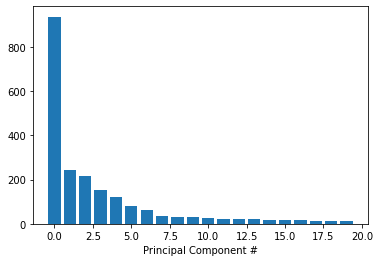

In [12]:
n_components = 20

# project data onto components
pca = PCA(n_components, random_state=10)
pca.fit(scaled_train_features)
pca_projection = pca.transform(scaled_train_features)


[0.36772564 0.46326458 0.54762527 ... 1.         1.         1.        ]
[0.36772564 0.46326458 0.54762527 0.60848193 0.65593566 0.68675871
 0.71148033 0.72523339 0.73764209 0.74974574 0.75930284 0.76846715
 0.77720721 0.78518157 0.79224139 0.79857207 0.80444394 0.80991826
 0.81493629 0.81959599]


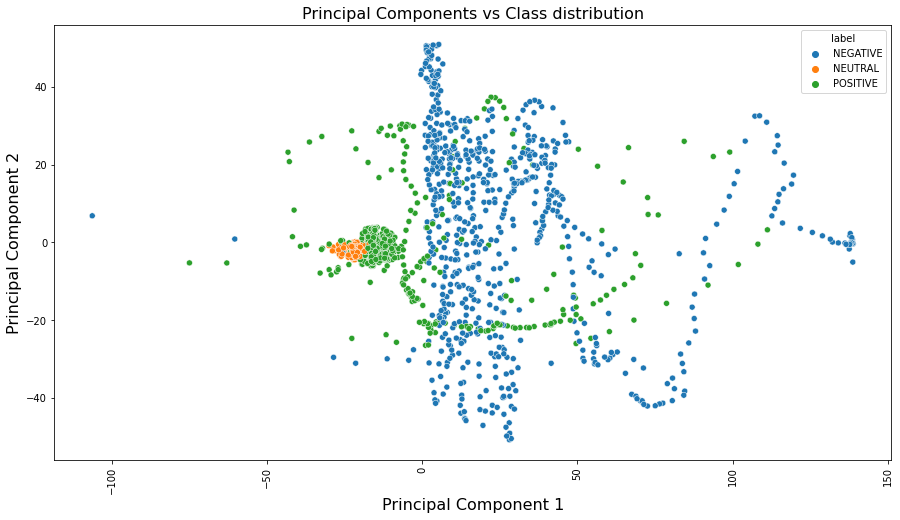

In [13]:
#Do a scatter plot of the data on the plane spanned by the first 2 components with class as color.
plt.figure(figsize=(15,8))
sns.scatterplot(x=pca_projection[:, 0], y=pca_projection[:, 1], hue=labels)
plt.title('Principal Components vs Class distribution', fontsize=16)
plt.ylabel('Principal Component 2', fontsize=16)
plt.xlabel('Principal Component 1', fontsize=16)
plt.xticks(rotation='vertical');

In [7]:
#Baseline algorithm : Logistic Regression
x_tot, y_tot = scaled_train_features, labels # x_tot, y_tot = features, labels
train_x, test_x, train_y, test_y = train_test_split(x_tot, y_tot)
from sklearn.linear_model import LogisticRegression
logreg=LogisticRegression(random_state=0,max_iter=1000)
logreg.fit(train_x,train_y)
pred_log=logreg.predict(test_x)
from sklearn.metrics import classification_report
print(classification_report(test_y, pred_log))
print(logreg.score(test_x,test_y))
#Cross validation
from sklearn.model_selection import cross_val_score
scores = cross_val_score(LogisticRegression(random_state=0,max_iter=1000), x_tot, y_tot, cv=5)
print(scores)
print(np.mean(scores))


In [49]:
#Tune the penalty type by doing a cross-validation
from sklearn.model_selection import GridSearchCV
param_grid = [{'penalty':['l1', 'l2', 'elasticnet', 'none']} ]
clf = GridSearchCV(LogisticRegression(random_state=0,max_iter=1000,solver='liblinear'), param_grid)
best_clf = clf.fit(train_x, train_y)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: penalty='none' is not supported for the liblinear solver

  FitFailedWarning)


In [54]:
pred_log=best_clf.predict(test_x)
from sklearn.metrics import classification_report
print(classification_report(test_y, pred_log))
print(best_clf.score(test_x,test_y))
print(clf.cv_results_)
print(clf.best_estimator_)
print(clf.best_score_)
print(clf.best_params_) #l1 is the best penalty

              precision    recall  f1-score   support

    NEGATIVE       0.94      0.98      0.96       168
     NEUTRAL       0.99      0.98      0.99       192
    POSITIVE       0.96      0.94      0.95       173

    accuracy                           0.97       533
   macro avg       0.97      0.97      0.97       533
weighted avg       0.97      0.97      0.97       533

0.9681050656660413
{'mean_fit_time': array([0.99176621, 4.40697699, 0.00771241, 0.00751061]), 'std_fit_time': array([4.89600937e-02, 1.92000089e-01, 1.33974050e-04, 5.61578553e-05]), 'mean_score_time': array([0.00342374, 0.00348911, 0.        , 0.        ]), 'std_score_time': array([2.91294040e-05, 1.09328747e-04, 0.00000000e+00, 0.00000000e+00]), 'param_penalty': masked_array(data=['l1', 'l2', 'elasticnet', 'none'],
             mask=[False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'penalty': 'l1'}, {'penalty': 'l2'}, {'penalty': 'elasticnet'}, {'penalty': 'none'}], 's

[0.81967213 0.82903981 0.87558685 0.86150235 0.82629108]
0.8424184450968104


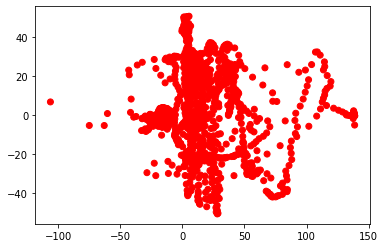

In [65]:
#4) Baseline on the PCA components
#component 1 : pca_projection[:, 0] 
#component 2 : pca_projection[:, 1]
pca_logreg=LogisticRegression(random_state=0,max_iter=1000)
scores = cross_val_score(pca_logreg, pca_projection[:, 0:1] , y_tot, cv=5)
pca_logreg.fit(pca_projection[:, 0:1],y_tot)
print(scores)
print(np.mean(scores))
#plot decision boundaries



In [75]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(["NEGATIVE", "POSITIVE", "NEUTRAL"])
print(le.classes_)
num_labels=le.transform(labels)
print(num_labels)

['NEGATIVE' 'NEUTRAL' 'POSITIVE']
[0 1 2 ... 0 0 1]


In [1]:
 #plotting the decision boundary : adapted dumbly from https://hackernoon.com/how-to-plot-a-decision-boundary-for-machine-learning-algorithms-in-python-3o1n3w07
n_classes = 3
plot_colors = "ryb"
plot_step = 0.02

# Load data
pairidx=0
pair=1

    # We only take the two corresponding features
X = pca_projection[:, 0:2]
y = num_labels

    # Train
clf = LogisticRegression(random_state=0,max_iter=1000).fit(X, y)

    # Plot the decision boundary
plt.subplot(2, 3, pairidx + 1)

x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))
plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
cs = plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu)

plt.xlabel(labels[0])
plt.ylabel(labels[1])

    # Plot the training points
for i, color in zip(range(n_classes), plot_colors):
    idx = np.where(y == i)
    plt.scatter(X[idx, 0], X[idx, 1], c=color, label=labels,
                    cmap=plt.cm.RdYlBu, edgecolor='black', s=15)

plt.suptitle("Decision surface of a decision tree using paired features")

plt.axis("tight")
#the result is weird : seems like only 2 classes are predicted ? I'm starting to get a bit lost at this point

NameError: ignored

In [22]:
#training 3 other algorithms
#baseline SVC
from sklearn.svm import SVC
svc = SVC()
svc.fit(train_x, train_y)
pred_svc=svc.predict(test_x)
from sklearn.metrics import classification_report
print(classification_report(test_y, pred_svc))
print(svc.score(test_x,test_y))
#param grid SVC
from sklearn.model_selection import GridSearchCV
param_grid = [{ 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000],
                    'kernel': ['linear','rbf']}] 
svc_grid = GridSearchCV(SVC(), param_grid)



              precision    recall  f1-score   support

    NEGATIVE       0.92      0.98      0.95       174
     NEUTRAL       1.00      0.96      0.98       177
    POSITIVE       0.94      0.92      0.93       182

    accuracy                           0.95       533
   macro avg       0.96      0.96      0.96       533
weighted avg       0.96      0.95      0.96       533

0.9549718574108818


In [23]:
#fitting the gridsearch
best_svc = svc_grid.fit(train_x, train_y)
pred_svc=best_svc.predict(test_x)

In [24]:
print(best_svc.score(test_x,test_y))
print(svc_grid.best_score_)
print(svc_grid.best_params_) #{'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}

0.9718574108818011
0.9699882445141066
{'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}


In [99]:
from sklearn.ensemble import RandomForestClassifier
#baseline Random Forest Classifier
rfc = RandomForestClassifier(random_state=0)
rfc.fit(train_x, train_y)
pred_rfc=clf.predict(test_x)
from sklearn.metrics import classification_report
print(classification_report(test_y, pred_rfc))
print(rfc.score(test_x,test_y))
#param grid for grid search
from sklearn.model_selection import GridSearchCV
param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}


              precision    recall  f1-score   support

    NEGATIVE       0.97      0.98      0.97       168
     NEUTRAL       0.99      0.99      0.99       192
    POSITIVE       0.97      0.97      0.97       173

    accuracy                           0.98       533
   macro avg       0.98      0.98      0.98       533
weighted avg       0.98      0.98      0.98       533

0.9774859287054409


NameError: ignored

In [102]:
CV_rfc = GridSearchCV(estimator=RandomForestClassifier(random_state=0), param_grid=param_grid)
CV_rfc.fit(train_x, train_y)
#fitting the grid search

In [108]:
pred_rfc=CV_rfc.predict(test_x)
from sklearn.metrics import classification_report
print(classification_report(test_y, pred_rfc))
print(CV_rfc.score(test_x,test_y))
print(CV_rfc.best_score_)
print(CV_rfc.best_params_) #{'criterion': 'entropy', 'max_depth': 7, 'max_features': 'auto', 'n_estimators': 500}

              precision    recall  f1-score   support

    NEGATIVE       0.98      0.98      0.98       168
     NEUTRAL       1.00      0.99      0.99       192
    POSITIVE       0.97      0.98      0.97       173

    accuracy                           0.98       533
   macro avg       0.98      0.98      0.98       533
weighted avg       0.98      0.98      0.98       533

0.9831144465290806
0.988123040752351
{'criterion': 'entropy', 'max_depth': 7, 'max_features': 'auto', 'n_estimators': 500}


In [8]:
from sklearn.neural_network import MLPClassifier
#baseline MLP
mlp_clf = MLPClassifier(random_state=0)
mlp_clf.fit(train_x, train_y)
pred_mlp=mlp_clf.predict(test_x)
from sklearn.metrics import classification_report
print(classification_report(test_y, pred_mlp))
print(mlp_clf.score(test_x,test_y))
#param grid for MLP Classifier
from sklearn.model_selection import GridSearchCV
param_grid = parameter_space = {
    'max_iter':[300,500,1000],
    'hidden_layer_sizes': [(50,50,50),(50,100,50), (100,)],
    'activation': ['tanh','relu'],
   # 'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    #'learning_rate': ['constant','adaptive'],
}
CV_mlp = GridSearchCV(estimator=MLPClassifier(random_state=0), param_grid=param_grid)


              precision    recall  f1-score   support

    NEGATIVE       0.97      0.99      0.98       181
     NEUTRAL       0.98      0.98      0.98       174
    POSITIVE       0.97      0.95      0.96       178

    accuracy                           0.97       533
   macro avg       0.97      0.97      0.97       533
weighted avg       0.97      0.97      0.97       533

0.9718574108818011


In [9]:
CV_mlp.fit(train_x, train_y) #fitting the grid search

GridSearchCV(cv=None, error_score=nan,
             estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                     batch_size='auto', beta_1=0.9,
                                     beta_2=0.999, early_stopping=False,
                                     epsilon=1e-08, hidden_layer_sizes=(100,),
                                     learning_rate='constant',
                                     learning_rate_init=0.001, max_fun=15000,
                                     max_iter=200, momentum=0.9,
                                     n_iter_no_change=10,
                                     nesterovs_momentum=True, power_t=0.5,
                                     random_st..., shuffle=True,
                                     solver='adam', tol=0.0001,
                                     validation_fraction=0.1, verbose=False,
                                     warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'

In [10]:
pred_mlp=CV_mlp.predict(test_x)
from sklearn.metrics import classification_report
print(classification_report(test_y, pred_mlp))
print(CV_mlp.score(test_x,test_y))
print(CV_mlp.best_score_)
print(CV_mlp.best_params_) #{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (50, 100, 50), 'max_iter': 300}

              precision    recall  f1-score   support

    NEGATIVE       0.96      0.99      0.98       181
     NEUTRAL       0.99      0.98      0.98       174
    POSITIVE       0.97      0.95      0.96       178

    accuracy                           0.97       533
   macro avg       0.97      0.97      0.97       533
weighted avg       0.97      0.97      0.97       533

0.9737335834896811
0.9743612852664576
{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (50, 100, 50), 'max_iter': 300}
